In [1]:
# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Sequence, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt


# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

warnings.filterwarnings("ignore")

# Add seed
np.random.seed(0)

# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

### Load Data


In [2]:
train_fp: str = "../../data/titanic/train_features.parquet"
train_fp1: str = "../../data/titanic/train_target.parquet"
test_fp: str = "../../data/titanic/test_features.parquet"
test_fp1: str = "../../data/titanic/test_target.parquet"

train_df: pl.DataFrame = pl.read_parquet(train_fp)
train_target_df: pl.DataFrame = pl.read_parquet(train_fp1)
test_df: pl.DataFrame = pl.read_parquet(test_fp)
test_target_df: pl.DataFrame = pl.read_parquet(test_fp1)

train_df.shape, train_target_df.shape, test_df.shape, test_target_df.shape

((1100, 11), (1100, 1), (328, 11), (328, 1))

In [3]:
train_df.head()

num_vars__age,num_vars__fare,num_vars__parch,num_vars__pclass,num_vars__sibsp,num_vars__ticket,cat_vars__embarked_c,cat_vars__embarked_q,cat_vars__embarked_s,cat_vars__sex_female,cat_vars__sex_male
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.524008,0.014737,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
0.19833,0.039525,0.111111,1.0,0.125,1.0,0.0,0.0,1.0,0.0,1.0
0.436325,0.039525,0.111111,1.0,0.125,1.0,0.0,0.0,1.0,1.0,0.0
0.348643,0.046845,0.0,0.5,0.125,1.0,1.0,0.0,0.0,1.0,0.0
0.373695,0.014151,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

In [5]:
data: pl.DataFrame = pl.concat([train_df, train_target_df], how="horizontal")
X: pd.DataFrame = data.to_pandas().drop(columns=["survived"])
y: pd.Series = data.to_pandas()["survived"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)
console.print(X_train.shape, X_val.shape)

(935, 11)
(165, 11)

In [6]:
y_train: npt.NDArray[np.float_ | np.int_] = y_train.values.reshape(-1, 1)
y_val: npt.NDArray[np.float_ | np.int_] = y_val.values.reshape(-1, 1)

console.print(y_train.shape, y_val.shape)

(935, 1)
(165, 1)

In [7]:
# create a 1D smoothing filter
def smooth(x, k=5):
    """This is used to smoothen the plot"""
    return np.convolve(x, np.ones(k) / k, mode="same")


def visualize_accuracy_n_loss(
    *, accuracy: Union[Sequence, np.ndarray], losses: torch.Tensor | list[float]
) -> None:
    """This is used to visualize the accuracy and loss per training epoch."""
    if isinstance(losses, list):
        losses = torch.tensor(losses)

    _, axs = plt.subplots(1, 2, figsize=(8, 6))

    axs[0].plot(smooth(losses.detach()))
    axs[0].set(xlabel="Epochs", ylabel="Training Loss", title="Losses")

    axs[1].plot(smooth(accuracy))
    axs[1].set(xlabel="Epochs", ylabel="Accuracy", title="Accuracy")
    plt.tight_layout()
    plt.show()

In [8]:
class TitanicClassifier(nn.Module):

    def __init__(self, input_size) -> None:
        super().__init__()
        # Hidden layer 1
        self.fc1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()

        # Hidden layer 2
        self.fc2 = nn.Linear(64, 64)
        self.relu2 = nn.ReLU()

        # Output layer
        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x) -> torch.Tensor:
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x


def train_model(
    *,
    model: nn.Module,
    learning_rate: float,
    epochs: int,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    display_loss: bool = False,
):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses = torch.zeros(size=(epochs,))
    accuracy = torch.zeros(size=(epochs,))

    for epoch_id in tqdm(range(epochs)):
        # Reset the gradients
        optimizer.zero_grad()
        # Forward propagtion
        y_pred: torch.Tensor = model(X_train)
        # Compute loss
        loss: torch.Tensor = criterion(y_pred, y_train)
        losses[epoch_id] = loss
        # Calculate accuracy
        accuracy[epoch_id] = (
            (y_pred > 0.5).float() == y_train.float()
        ).sum() / y_train.size(0)

        # Back propagation
        loss.backward()
        # Update parameters
        optimizer.step()
        if display_loss:
            if (epoch_id + 1) % 100 == 0:
                console.print(f"Epoch [{epoch_id+1}/{epochs}], Loss: {loss.item():.4f}")

    return model, losses, accuracy

In [9]:
(torch.tensor(0.8) > 0.6)  # .float()

tensor(True)

### With Data Loader

In [10]:
from torch.utils.data import DataLoader, TensorDataset


# Create datasets
train_dataset: TensorDataset = TensorDataset(
    torch.tensor(X_train.to_numpy()).float(),
    torch.tensor(y_train).float(),
)
val_dataset: TensorDataset = TensorDataset(
    torch.tensor(X_val.to_numpy()).float(),
    torch.tensor(y_val).float(),
)

train_dataloader: DataLoader = DataLoader(
    dataset=train_dataset, batch_size=16, shuffle=True, drop_last=True
)
val_dataloader: DataLoader = DataLoader(
    dataset=val_dataset, batch_size=1, shuffle=False
)

train_dataloader, val_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x13f4739d0>,
 <torch.utils.data.dataloader.DataLoader at 0x13f3d8950>)

In [11]:
train_dataloader.dataset.tensors[0].shape

torch.Size([935, 11])

In [12]:
y: torch.Tensor = torch.Tensor([[0.45, 0.55], [0.7, 0.3]])
torch.argmax(y, dim=1)

tensor([1, 0])

In [13]:
def train_model(
    *,
    model: nn.Module,
    learning_rate: float,
    epochs: int,
    train_dataloader: DataLoader,
    validation_dataloader: DataLoader,
    display_loss: bool = False,
):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    training_losses: list[float] = []
    val_losses: list[float] = []

    training_accuracy: list[float] = []
    val_accuracy: list[float] = []

    for epoch_id in tqdm(range(epochs)):
        batch_losses: list[float] = []
        batch_accuracy: list[float] = []

        for X_t, y_tr in train_dataloader:
            # Reset the gradients
            optimizer.zero_grad()

            # Forward propagtion
            y_proba: torch.Tensor = model(X_t)

            # Compute batch loss
            loss: torch.Tensor = criterion(y_proba, y_tr)
            batch_losses.append(loss.detach().numpy())

            # Back propagation
            loss.backward()
            # Update parameters
            optimizer.step()

            # Compute batch accuracy
            y_pred: torch.Tensor = torch.argmax(y_proba, axis=1)
            batch_acc = torch.mean((y_pred == y_tr).float()) * 100
            batch_accuracy.append(batch_acc.detach().numpy())

        # Training loss and accuracy
        training_losses.append(np.mean(batch_losses))
        training_accuracy.append(np.mean(batch_accuracy))

        # Validation
        X_val, y_val = next(iter(validation_dataloader))
        y_proba_val: torch.Tensor = model(X_val)
        y_pred_val: torch.Tensor = torch.argmax(y_proba_val, axis=1)

        # Loss
        val_loss: torch.Tensor = criterion(y_proba_val, y_val)
        val_acc: torch.Tensor = torch.mean((y_pred_val == y_val).float())
        val_losses.append(val_loss)
        val_accuracy.append(val_acc)

        if display_loss:
            if (epoch_id + 1) % 100 == 0:
                console.print(f"Epoch [{epoch_id+1}/{epochs}], Loss: {loss.item():.4f}")

    return model, training_losses, training_accuracy, val_accuracy

In [14]:
epochs: int = 100
learning_rate: float = 0.01
model = TitanicClassifier(input_size=11)


model, training_losses, training_accuracy, val_accuracy = train_model(
    model=model,
    learning_rate=learning_rate,
    epochs=epochs,
    train_dataloader=train_dataloader,
    validation_dataloader=val_dataloader,
)

console.print(f"Training accuracy: {np.mean(training_accuracy):.2f}%")

  0%|          | 0/100 [00:00<?, ?it/s]

Training accuracy: 50.14%

In [15]:
console.print(np.min(training_losses), np.max(training_losses))
console.print(np.min(training_accuracy), np.max(training_accuracy))

0.58503133 0.62634254

49.78448 50.431034

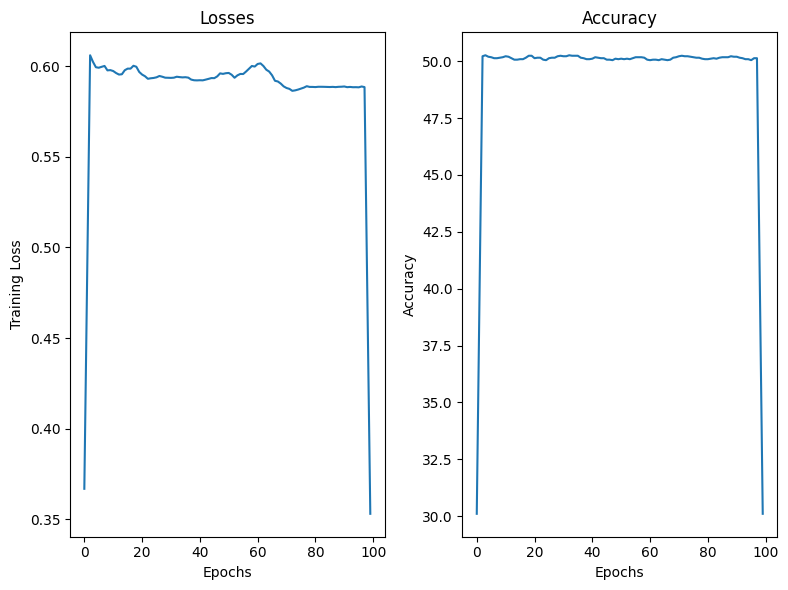

In [16]:
visualize_accuracy_n_loss(accuracy=training_accuracy, losses=training_losses)

In [17]:
X_test: torch.Tensor = torch.Tensor(test_df.to_numpy()).float()
y_test: torch.Tensor = torch.Tensor(test_target_df.to_numpy()).float()

y_proba: torch.Tensor = model(X_test)
y_pred = (y_proba > 0.5).int()

In [18]:
from sklearn.metrics import accuracy_score, roc_auc_score


acc_score = accuracy_score(y_test.reshape(-1, 1), y_pred)
auc_score = roc_auc_score(y_test.reshape(-1, 1), y_pred)

In [19]:
acc_score, auc_score

(0.8262195121951219, 0.8104236453201972)